In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib
import LinearResponseVariationalBayes.ModelSensitivity as sens_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load results from previous fit.

In [2]:
json_input_file = os.path.join('./iris_fits_for_nips/bnp_full_data_fit_alpha3.5_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [4]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 0.37616072 -0.83707702  0.54884496 -0.7575262   0.2689322  -0.0696174
  -0.09108048 -0.0901519  -0.0830252  -0.07363194 -0.06329507 -0.04748658]
 [-0.2382035   0.36417318 -0.04613331 -0.46864103 -0.41126225 -0.25698699
  -0.25486633 -0.24619905 -0.23239487 -0.21276703 -0.18742608 -0.25461831]
 [ 0.93168929 -2.29445008  1.6196464   0.69768906  1.65617262  0.65492876
   0.57377396  0.50052968  0.42774972  0.35628876  0.28845206  0.68913405]
 [ 0.27920097 -0.95459394  0.91779967  0.4274394   0.29205     0.23685243
   0.20018611  0.16565304  0.1329439   0.1035606   0.07862009  0.25047796]]
	cluster_weights:
[0.44006818 0.32630923 0.19817012 0.00866061 0.00772923 0.00431383
 0.00328868 0.00252916 0.00195602 0.00151891 0.0011831  0.00427294]
	v_sticks:
[-0.24245967  0.33802859  1.79311681 -1.33902551 -1.07519277 -1.52972003
 -1.56822299 -1.59596054 -1.61658644 -1.63195125 -1.64325976]


In [5]:
print(model.prior_params)

prior_params:
	alpha: [3.5]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [6]:
alpha0 = model.prior_params['alpha'].get()[0]
print(alpha0)

3.5


# Define a perturbation in the logit v space.

In [7]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.

phi_center = 2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))



0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [47]:
logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                               prior_perturbation.logit_v_ub, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 5 * log_phi(logit_v) / log_phi_max


phi max:  0.4997727846542519
log phi max:  50.69314718055995


In [48]:
prior_perturbation = fun_sens_lib.PriorPerturbation(
    model, rescaled_log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)
prior_perturbation.objective.logger.print_every = 10

-1.2527629265819875 -0.7031949008901544 -1.253936900542948 -0.702028882429559


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


Text(0.5,1,'Priors in logit space')

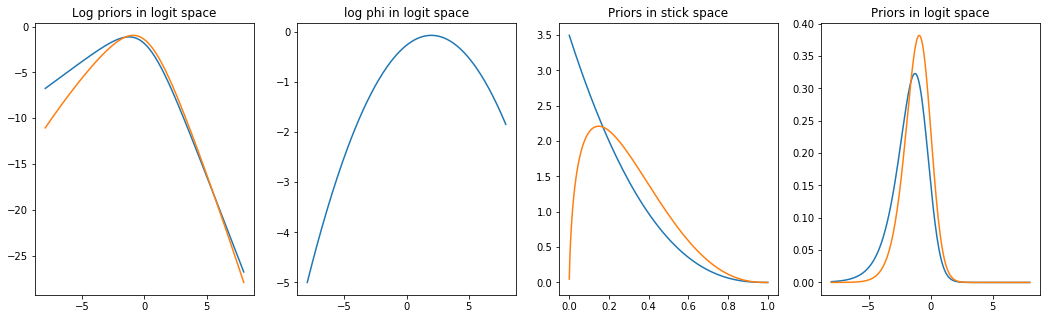

In [49]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


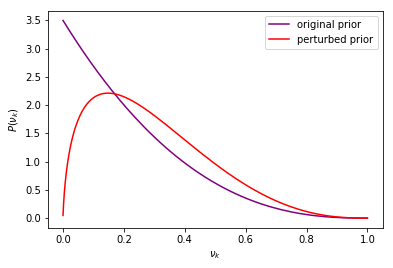

In [51]:
prior_perturbation.set_epsilon(1.0)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)), color = 'purple')
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)), color = 'red')

plt.ylabel('$P(\\nu_k)$')
plt.xlabel('$\\nu_k$')
plt.legend(('original prior', 'perturbed prior'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/perturbed_prior1_init3_5.png')

In [52]:
prior_plot_array = np.array([v_grid, 
                            np.exp(prior_perturbation.get_log_p0(v_grid)), 
                            np.exp(prior_perturbation.get_log_pc(v_grid))])

In [53]:
# np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert2.csv', 
#           prior_plot_array, delimiter = ',')

# Choose the number of GH points.

In [54]:
# Sanity check the perturbation

# gmm_utils.set_gauss_hermite_points(
#     prior_perturbation.model.vb_params, gh_deg=10)
#
# prior_perturbation.set_epsilon(1.0)
# print(prior_perturbation.get_e_log_perturbation(sum_vector=False))
#
# prior_perturbation.set_epsilon(0.5)
# print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

prior_perturbation.set_epsilon(1.0)

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=1)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=2)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=10)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


[0.28926809 0.18069085 0.07898569 0.18659581 0.18501944 0.19643224
 0.19779529 0.1984147  0.19859176 0.19862568 0.19863297]
[0.29052441 0.18306357 0.08704901 0.2045426  0.20705202 0.22050236
 0.22239856 0.2231938  0.22342284 0.22347242 0.22348506]
[0.29052441 0.18306357 0.08704901 0.2045426  0.20705202 0.22050236
 0.22239856 0.2231938  0.22342284 0.22347242 0.22348506]


In [55]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(1.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
print(expected_perturbations_list[1])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_list[gh_deg_threshold])
print('Chosen gh_dg = {}, learned threshold = {}, checked_points = {}'
      .format(gh_deg, gh_deg_list[gh_deg_threshold], len(max_diffs)))

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


[0.3176641  0.20693023 0.08097603 0.66455596 0.58132858 0.74696744
 0.76422167 0.77685559 0.78630722 0.79335621 0.79853988]
[0.3176641  0.20693023 0.08097603 0.66455596 0.58132858 0.74696744
 0.76422167 0.77685559 0.78630722 0.79335621 0.79853988]
[3.49494809e-16 1.90979965e-16 7.63919861e-16 5.71648893e-16
 5.64777526e-16 4.23583145e-16 2.82388763e-16 5.64777526e-16
 5.14137960e-16 5.24242214e-16 4.17094374e-16 5.72939896e-16
 5.72939896e-16 4.28736670e-16 3.81959931e-16 5.72939896e-16
 1.90979965e-16 3.49494809e-16 5.59759469e-16 4.19819602e-16
 2.79879734e-16 3.49494809e-16 4.19819602e-16 2.79879734e-16
 1.74747405e-16 2.97261027e-16 4.45891540e-16 4.35824429e-16
 4.17094374e-16 3.34124262e-16 3.49494809e-16 3.42758640e-16
 3.34124262e-16 3.34124262e-16 3.81959931e-16 5.01186394e-16
 3.49494809e-16 3.49494809e-16 3.49494809e-16 1.90979965e-16
 4.35824429e-16 2.85824447e-16 4.17094374e-16 2.82388763e-16
 2.90549619e-16 3.42758640e-16 3.49494809e-16 3.42758640e-16
 2.97261027e-16 4.35

In [56]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)
model.objective.logger.initialize()

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.270059446445549	 Objective: -322.0726278609656
Optimization terminated successfully.
         Current function value: -322.072628
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
         Current function value: -322.072628
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


# Examine Fit 

In [57]:
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)

In [58]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [59]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(
        pca_fit, bnp_centroids, bnp_cluster_covs)

Text(0,0.5,'PC2')

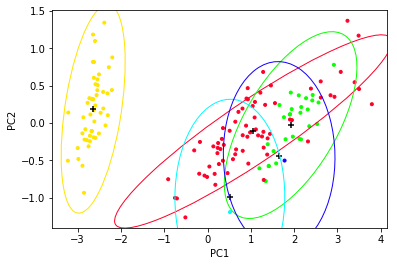

In [60]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

# plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/init_fit_alph8.0.png')

# Define prior perturbation

In [61]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    sens_lib.ParametricSensitivityLinearApproximation(
        objective_functor=prior_perturbation.get_perturbed_kl,
        input_par=prior_perturbation.model.global_vb_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_val0=best_param_0,
        hyper_val0=np.array([0.0]),
        input_is_free=True,
        hyper_is_free=False,
        hyper_par_objective_functor=prior_perturbation.get_e_log_perturbation)

# epsilon_sensitivity = \
#     obj_lib.ParametricSensitivity(
#         objective_fun=model.set_z_get_kl,
#         input_par=prior_perturbation.model.global_vb_params,
#         output_par=moment_model.moment_params,
#         hyper_par=prior_perturbation.epsilon_param,
#         input_to_output_converter=moment_model.set_moments,
#         optimal_input_par=best_param_0,
#         objective_hessian=kl_hessian_0,
#         hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [62]:
prior_perturbation.set_epsilon(0.0)
print(prior_perturbation.get_e_log_perturbation())

prior_perturbation.set_epsilon(1.0)
print(prior_perturbation.get_e_log_perturbation())

print(np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper()))

-0.0
6.517887001262942
2.7320039462590864


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


## Fit with perturbation

In [63]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
# output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
#     epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  2.7320039462590864


In [64]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)


best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


Iter  0  value:  -315.3110849214355
Optimization terminated successfully.
         Current function value: -316.362731
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 0
         Current function value: -316.362731
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 1.687538730201931


Epsilon: 1.0


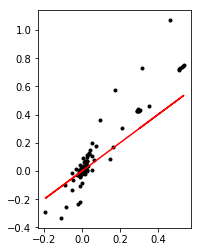

In [65]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [66]:
print('original expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_0, model))

print('perturbed expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi, model))

print('predicted expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi_pred, model))

original expected number of clusters:  5.368886222818921
perturbed expected number of clusters:  5.236702714359211
predicted expected number of clusters:  5.132312902291457


# Predict for a range of perturbations

In [67]:
epsilon_vec = np.append(np.linspace(0, 0.1, 6), np.linspace(0.2, 1.0, 6))
print(epsilon_vec)

[0.   0.02 0.04 0.06 0.08 0.1  0.2  0.36 0.52 0.68 0.84 1.  ]


In [68]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

prior_perturbation.objective.logger.print_every = 10

for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = \
        gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi_pred, model)
    
#     epsilon_sensitivity.predict_output_par_from_hyperparameters(
#         epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.objective.logger.initialize()
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

#     output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
    output_phi = \
        gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi, model)

    print('Done. Converged: ', converged)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    



Epsilon:  0.0
Predicted differences:  0.0
epsilon: 0.0
Iter  0  value:  -322.07262787588564
         Current function value: -322.072628
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.0
Actual differences: (This is nonzero if phi did anything): 5.9650227134669265e-15


Epsilon:  0.02
Predicted differences:  0.05464007892518166
epsilon: 0.02


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.710244e-07
  AccuracyWarning)


Iter  0  value:  -321.94272685119483
Optimization terminated successfully.
         Current function value: -321.942727
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
         Current function value: -321.942727
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.05464007892518166
Actual differences: (This is nonzero if phi did anything): 0.05398468534064366


Epsilon:  0.04
Predicted differences:  0.10928015785036346
epsilon: 0.04


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.199928e-06
  AccuracyWarning)


Iter  0  value:  -321.8137199599435
Optimization terminated successfully.
         Current function value: -321.813723
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -321.813723
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.10928015785036346
Actual differences: (This is nonzero if phi did anything): 0.10647334021537165


Epsilon:  0.06
Predicted differences:  0.16392023677554507
epsilon: 0.06


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.608508e-06
  AccuracyWarning)


Iter  0  value:  -321.685573629736
Optimization terminated successfully.
         Current function value: -321.685591
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0
         Current function value: -321.685591
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.16392023677554507
Actual differences: (This is nonzero if phi did anything): 0.15723013174609396


Epsilon:  0.08


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.915673e-06
  AccuracyWarning)


Predicted differences:  0.21856031570072698
epsilon: 0.08
Iter  0  value:  -321.55824822705483
Optimization terminated successfully.
         Current function value: -321.558303
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0
         Current function value: -321.558303
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.21856031570072698
Actual differences: (This is nonzero if phi did anything): 0.20615228482210218


Epsilon:  0.1
Predicted differences:  0.2732003946259087
epsilon: 0.1


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.137792e-06
  AccuracyWarning)


Iter  0  value:  -321.43169823997795
Optimization terminated successfully.
         Current function value: -321.431835
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0
         Current function value: -321.431835
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.2732003946259087
Actual differences: (This is nonzero if phi did anything): 0.2532878833922259


Epsilon:  0.2
Predicted differences:  0.5464007892518172
epsilon: 0.2


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.404231e-06
  AccuracyWarning)


Iter  0  value:  -320.80860889374117
Optimization terminated successfully.
         Current function value: -320.811002
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0
         Current function value: -320.811002
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.5464007892518172
Actual differences: (This is nonzero if phi did anything): 0.4678176647936456


Epsilon:  0.36


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.662198e-06
  AccuracyWarning)


Predicted differences:  0.983521420653271
epsilon: 0.36
Iter  0  value:  -319.8276520568281
Optimization terminated successfully.
         Current function value: -319.853378
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 0
         Current function value: -319.853378
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.983521420653271
Actual differences: (This is nonzero if phi did anything): 0.7658600701441943


Epsilon:  0.52
Predicted differences:  1.420642052054725
epsilon: 0.52


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.670852e-07
  AccuracyWarning)


Iter  0  value:  -318.82834760761284
Optimization terminated successfully.
         Current function value: -318.934029
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 0
         Current function value: -318.934029
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  1.420642052054725
Actual differences: (This is nonzero if phi did anything): 1.0295947597910562


Epsilon:  0.6799999999999999
Predicted differences:  1.8577626834561785
epsilon: 0.6799999999999999


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.705452e-07
  AccuracyWarning)


Iter  0  value:  -317.7666192658224
Optimization terminated successfully.
         Current function value: -318.048155
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 0
         Current function value: -318.048155
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  1.8577626834561785
Actual differences: (This is nonzero if phi did anything): 1.2680917672587293


Epsilon:  0.8400000000000001
Predicted differences:  2.2948833148576333
epsilon: 0.8400000000000001


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.225609e-07
  AccuracyWarning)


Iter  0  value:  -316.6042696479413
Optimization terminated successfully.
         Current function value: -317.192048
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -317.192048
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  2.2948833148576333
Actual differences: (This is nonzero if phi did anything): 1.4862541785507146


Epsilon:  1.0
Predicted differences:  2.7320039462590864
epsilon: 1.0


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954440e-08
  AccuracyWarning)


Iter  0  value:  -315.3110849214355
Optimization terminated successfully.
         Current function value: -316.362731
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 0
         Current function value: -316.362731
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  2.7320039462590864
Actual differences: (This is nonzero if phi did anything): 1.687538730201931


In [69]:
# np.save('best_param_phi_array', best_param_phi_array)

In [70]:
# output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)
output_0 = \
    gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_0, model)


In [71]:
# for i in range(len(epsilon_vec)): 
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_pred_array[i] - best_param_0, 'k.')
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_array[i] - best_param_0, 'r')
#     plt.xlabel('true diff global free params')
#     plt.ylabel('pred diff global free params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))

#     plt.subplot(1, 2, 2)
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_pred_array[i] - output_0, 'k.')
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_array[i] - output_0, 'r')
#     plt.xlabel('true diff moment params')
#     plt.ylabel('pred diff moment params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
#     plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [72]:
# # This expects the hyperparameter to be at its optimal value.
# #e_num_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
# #e_num_clusters_class = gmm_utils.ExpectedNumClustersFromLogitSticks(model)
# e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

# prior_perturbation.set_epsilon(0.0)
# cluster_sensitivity = \
#     obj_lib.ParametricSensitivity(
#         objective_fun=model.set_z_get_kl,
#         input_par=e_num_clusters_class.model.global_vb_params,
#         output_par=e_num_clusters_class.e_num_clusters,
#         hyper_par=prior_perturbation.epsilon_param,
#         input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
#         optimal_input_par=best_param_0,
#         objective_hessian=kl_hessian_0,
#         hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [83]:
e_num_clusters_pred = []
e_num_clusters_true = []
for i in range(len(epsilon_vec)):
    e_num_clusters_pred.append(
        gmm_utils.get_e_num_clusters_from_free_par(
            best_param_phi_pred_array[i], model))
    e_num_clusters_true.append(
        gmm_utils.get_e_num_clusters_from_free_par(
            best_param_phi_array[i], model))
    
e_num_post_pred_clusters_pred = []
e_num_post_pred_clusters_true = []
for i in range(len(epsilon_vec)):
    e_num_post_pred_clusters_pred.append(
        gmm_utils.get_e_num_pred_clusters_from_free_par(
            best_param_phi_pred_array[i], model))
    e_num_post_pred_clusters_true.append(
        gmm_utils.get_e_num_pred_clusters_from_free_par(
            best_param_phi_array[i], model))

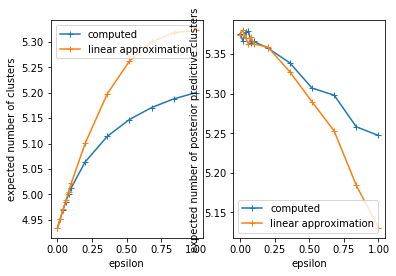

In [85]:
plt.subplot(121)
plt.plot(epsilon_vec, e_num_clusters_true, '+-')
plt.plot(epsilon_vec, e_num_clusters_pred, '+-')
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.legend(('computed', 'linear approximation'))

plt.subplot(122)
plt.plot(epsilon_vec, e_num_post_pred_clusters_true, '+-')
plt.plot(epsilon_vec, e_num_post_pred_clusters_pred, '+-')
plt.xlabel('epsilon')
plt.ylabel('expected number of posterior predictive clusters')
plt.legend(('computed', 'linear approximation'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/pred_num_clusters1_init3_5.png')

[0.44006792 0.32630923 0.19817027 0.00866056 0.00772926 0.00431381
 0.00328868 0.00252917 0.00195603 0.00151892 0.00118311 0.00427303]


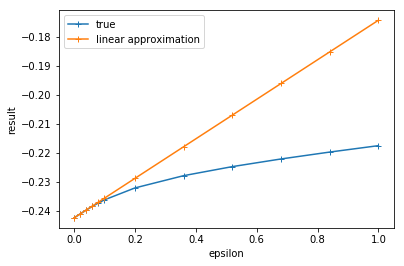

In [87]:
# Look at generic quantities.
model.global_vb_params.set_free(best_param_0)
print(model.get_e_cluster_probabilities())

def get_result(free_par, model):
    model.global_vb_params.set_free(free_par)
    #return 1 / np.sqrt(model.global_vb_params['v_sticks']['info'].get()[0])
    return model.global_vb_params['v_sticks']['mean'].get()[0]

result_pred = []
result_true = []
for i in range(len(epsilon_vec)):
    result_pred.append(get_result(best_param_phi_pred_array[i], model))
    result_true.append(get_result(best_param_phi_array[i], model))

    
plt.plot(epsilon_vec, result_true, '+-')
plt.plot(epsilon_vec, result_pred, '+-')

plt.xlabel('epsilon')
plt.ylabel('result')

plt.legend(('true', 'linear approximation'))


In [76]:
np.array(e_num_clusters_true)

array([4.93347445, 4.95163196, 4.96892051, 4.98501416, 4.99973923,
       5.01308693, 5.06365142, 5.11414471, 5.14735799, 5.17091931,
       5.18799509, 5.20035556])

In [77]:
func_sens_results_array = np.array([epsilon_vec, 
                                   np.array(e_num_clusters_true).squeeze(), 
                                   np.array(e_num_clusters_pred).squeeze()])

# np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert2_enum_clust_results.csv', 
#         func_sens_results_array, 
#           delimiter = ',')

In [78]:
def plot_results_from_free_params(model, global_free_params, fig): 
    # look at results
    model.global_vb_params.set_free(global_free_params)
    model.set_optimal_z()

    bnp_clusters = np.argmax(model.e_z, axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
        
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')


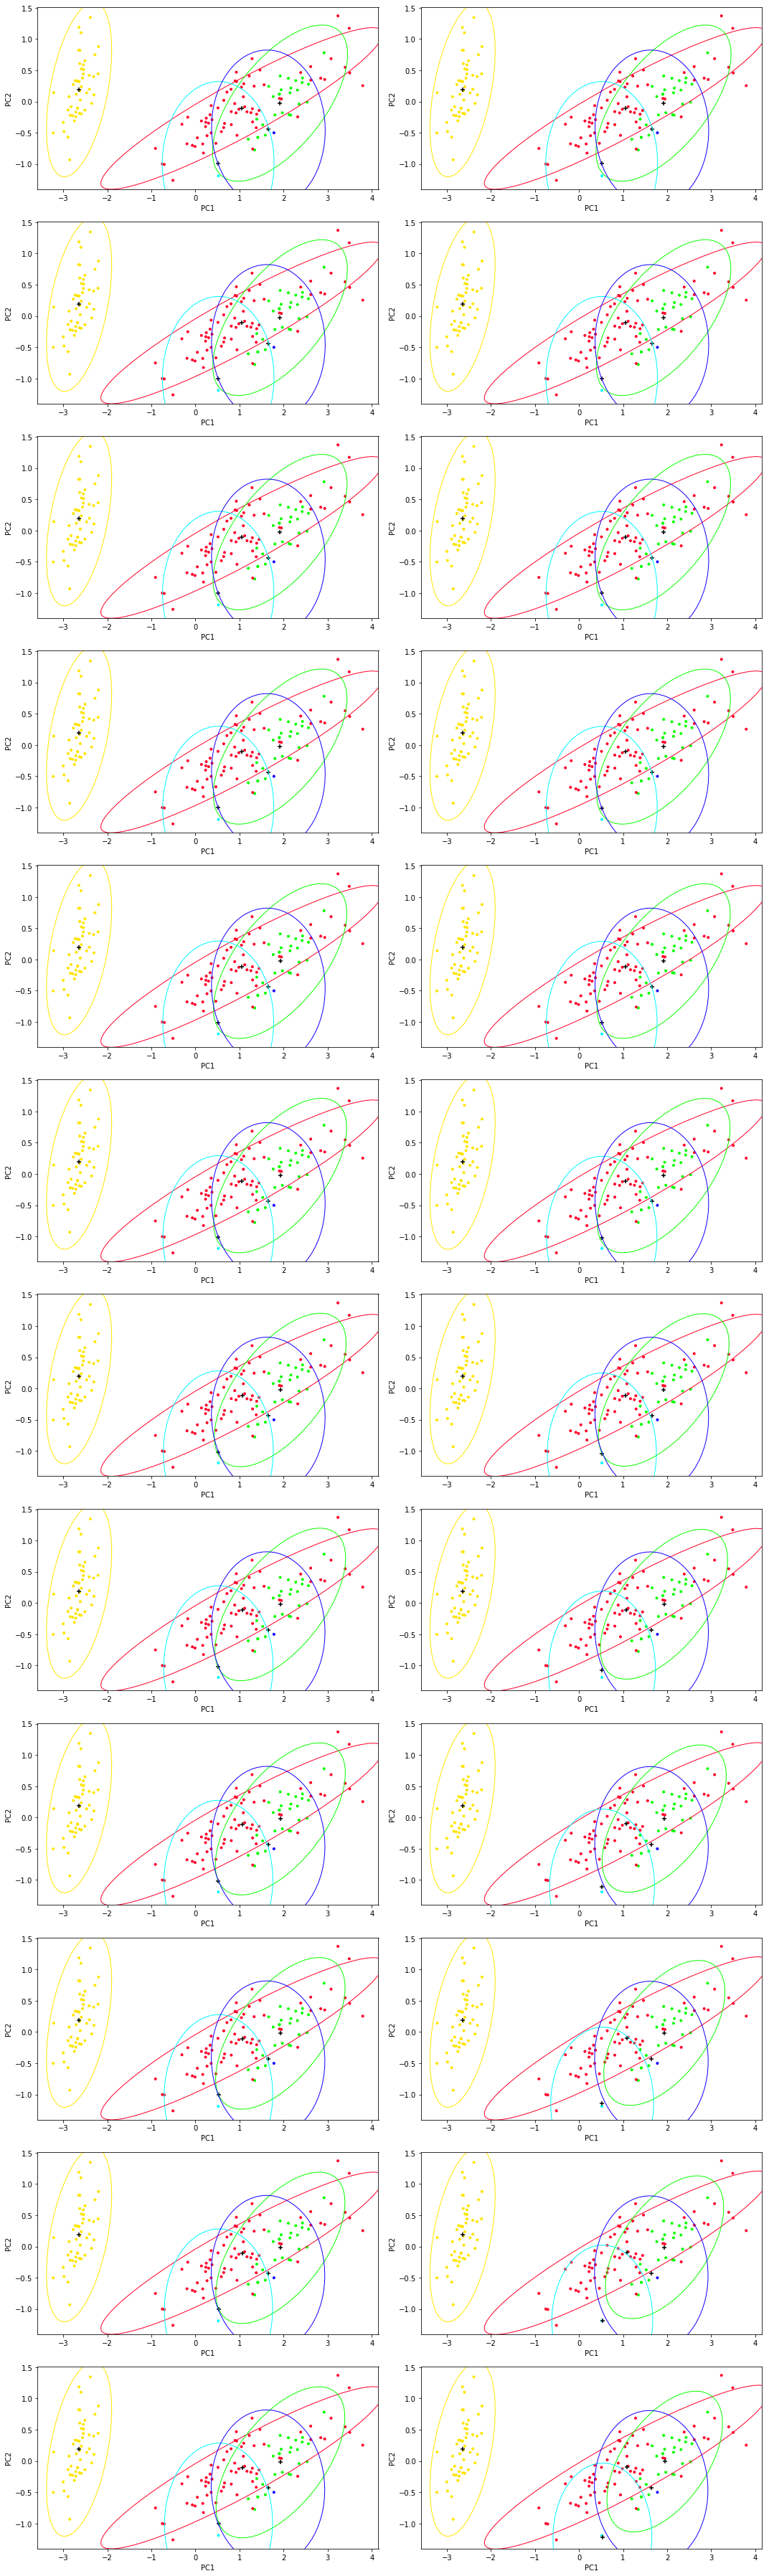

In [79]:
f, axarr = plt.subplots(len(epsilon_vec), 2, figsize = (15, 50))

for i in range(len(epsilon_vec)): 
    plot_results_from_free_params(model, best_param_phi_array[i], axarr[i, 0])
    plot_results_from_free_params(model, best_param_phi_pred_array[i], axarr[i, 1])

f.tight_layout()